In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import importlib
from cycler import cycler
from pathlib import Path
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
# import utils
# importlib.reload(utils)

In [4]:
# Import Data
# file_paths = ['Data\task1-3_1v.txt', 'Data\task1-3_1v.txt', 'Data\task1-3_1v.txt']
file_paths = [r'Data\contact-potential_6V.txt', r'Data\contact-potential_7V.txt']
internal_resistance = 27 # Ohm
data_dict = {}
data_dict['6V'] = pd.read_csv(file_paths[0], sep=r'\s+', header=None, names=['x', 'y'])
data_dict['7V'] = pd.read_csv(file_paths[1], sep=r'\s+', header=None, names=['x', 'y'])

for key in data_dict:
    # Remove repeated x-values (keep the first occurrence)
    data_dict[key] = data_dict[key].drop_duplicates(subset='x', keep='first')

    # Sort by x to ensure monotonicity
    data_dict[key] = data_dict[key].sort_values(by='x').reset_index(drop=True)

min_len = min(len(data_dict['6V']) - 1, len(data_dict['7V']))    # Subtracted 1 from 6V to remove outlier data point
data_dict['6V'] = data_dict['6V'].iloc[:min_len].reset_index(drop=True)
data_dict['7V'] = data_dict['7V'].iloc[:min_len].reset_index(drop=True)

for key, data in data_dict.items():
    data_dict[key]['I'] = data['y'] / internal_resistance

In [5]:
##########################################################
# Preliminary plot just to check the data, not for use #
##########################################################


# fig, ax = plt.subplots(figsize=(10, 6))
# ax.set(xlabel='$U_{acc}$ [V]', ylabel='Current [A]', title='Acceleration Voltage vs Electron Current')
# for key, data in data_dict.items():
#     ax.plot(data['x'], data['I'], label=key, lw=1)
# ax.set_yscale('log')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, ncol=2, fontsize=9)
# ax.legend()
# plt.show()
    

In [6]:
x_lin_mins = {
    '6V': 0.12,
    '7V': 0.05
}
x_lin_maxes = {
    '6V': 0.95,
    '7V': 0.45
}

x_plateau_mins = {
    '6V': 12,
    '7V': 12.5
}
x_plateau_maxes = {
    '6V': 14,
    '7V': 14
}

contact_df = pd.DataFrame(columns=['Heating Voltage', 'U_contact'])
fit_dict = {}
for key, data in data_dict.items():
    fit_dict[key] = {}
    x = data['x'].values
    y = data['I'].values

    mask_linear = (x >= x_lin_mins[key]) & (x <= x_lin_maxes[key])
    mask_plateau = (x >= x_plateau_mins[key]) & (x <= x_plateau_maxes[key])

    x_linear, y_linear = x[mask_linear], np.log10(y[mask_linear])
    x_plateau, y_plateau = x[mask_plateau], np.log10(y[mask_plateau])

    m1, b1 = np.polyfit(x_linear, y_linear, 1)
    m2, b2 = np.polyfit(x_plateau, y_plateau, 1)

    fit_dict[key] = {
        'm1': m1,
        'b1': b1,
        'm2': m2,
        'b2': b2
    }

    U_contact = (b2 - b1) / (m1 - m2)
    print(f"{key} Contact Potential: {U_contact:.2f} V")
    # Append contact potential to DataFrame
    contact_df.loc[len(contact_df)] = [key, U_contact]
    

6V Contact Potential: 2.07 V
7V Contact Potential: 1.95 V


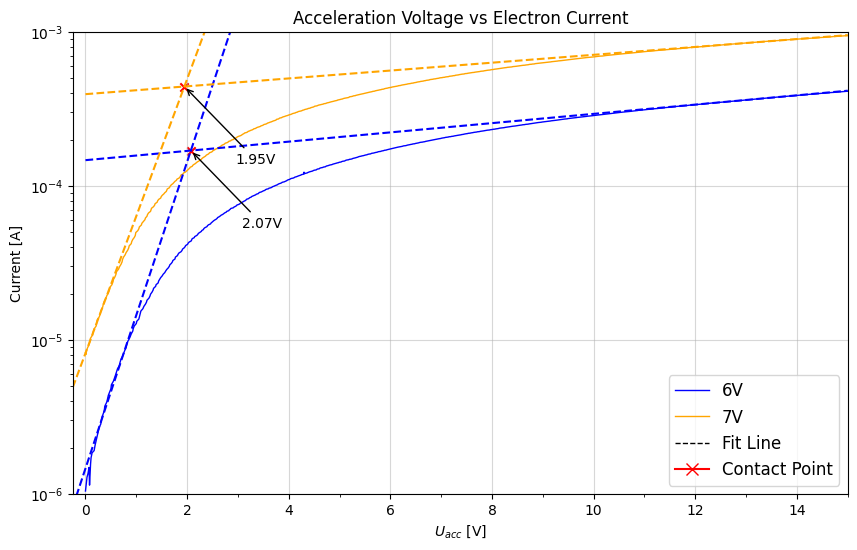

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

line_colors = {'6V': 'blue', '7V': 'orange'}
ax.set(xlabel='$U_{acc}$ [V]', ylabel='Current [A]', title='Acceleration Voltage vs Electron Current')
for key, data in data_dict.items():
    ax.plot(data['x'], data['I'], label=key, lw=1, color=line_colors[key])

# Plot the linear fits
for key, data in fit_dict.items():

    x_fit_linear = np.linspace(-0.25, 3, 100)
    y_fit_linear = 10**(data['m1'] * x_fit_linear + data['b1'])
    ax.plot(x_fit_linear, y_fit_linear, label=f'{key} Linear Fit', linestyle='--', color=line_colors[key])

    x_fit_plateau = np.linspace(0, 15, 100)
    y_fit_plateau = 10**(data['m2'] * x_fit_plateau + data['b2'])
    ax.plot(x_fit_plateau, y_fit_plateau, label=f'{key} Plateau Fit', linestyle='--', color=line_colors[key])
    
    # Plot the contact point

    U_contact = contact_df.loc[contact_df['Heating Voltage'] == key, 'U_contact'].values[0]
    
    ax.scatter(U_contact, 10**(data['m1'] * U_contact + data['b1']),
               color='red', marker='x', label=f'{key} Contact Point')
    ax.annotate(f'{U_contact:.2f}V', 
                (U_contact, 10**(data['m1'] * U_contact + data['b1'])),
                xytext=(U_contact + 1, 10**(data['m1'] * U_contact + data['b1'] - 0.5)),
                arrowprops=dict(arrowstyle='->', color='black')
                ) 


# ax2.annotate(f'Peak at x={x_peak[max_index]:.2f} V',
#                         xy=(x_peak[max_index], max_deriv),
#                         xytext=(x_peak[max_index] + 0.95, max_deriv),
#                         arrowprops=dict(arrowstyle='->', color='red'),
#                         fontsize=10, color='red')




#ax.axvline(x=x_plateau_mins['7V'], color='black', linestyle='-', lw=0.5)
#ax.axvline(x=x_lin_mins['6V'], color='black', linestyle='-', lw=0.5)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_major_locator(MultipleLocator(1e-5))
ax.set_xlim(-0.25, 15)
ax.set_ylim(1e-6, 1e-3)
ax.grid(which='major', axis='both', alpha=0.5)
ax.set_yscale('log')
handles = [
    Line2D([], [], color='blue', linestyle='-', lw=1, label='6V'),
    Line2D([], [], color='orange', linestyle='-', lw=1, label='7V'),
    Line2D([], [], color='black', linestyle='--', lw=1, label='Fit Line'),
    Line2D([], [], color='red', marker='x', markersize=8, label='Contact Point')
]
ax.legend(handles=handles, loc='best', fontsize=12)

plt.show()
    

In [8]:
contact_potential = contact_df['U_contact'].mean()
print(f"Average Contact Potential: {contact_potential:.2f} V")

Average Contact Potential: 2.01 V
